### Imports

In [1]:
import torch
print(f'PyTorch CUDA is available? {torch.cuda.is_available()}')
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

PyTorch CUDA is available? True


In [2]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, MultiStepLR

In [3]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

### Fix randomness for reproducibility

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

## Devices availables

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


### Hyperparameters

In [7]:
cfg = {
    # Prepare dataloader
    'n_classes': 43,
    'std_size': 260,
    'rand_crop_size': 150,
    'batch_size': 64,

    # Compilation of network
    'epochs': 30,
    'lr': 3e-4, # 1e-3
    'wd': 3e-5, # 1e-4
}

## Access dataloader

In [8]:
# !git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [9]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [10]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [11]:
from torchvision import transforms as T, datasets

In [12]:
## Rimettere a 260x260 o a 224x224 (per resnet)

tsfms_std = T.Compose([
    T.Resize(size=(cfg['std_size'], cfg['std_size'])),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])

tsfms_increasing = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(size=(cfg['rand_crop_size'], cfg['rand_crop_size']), scale=(0.7, 0.9)),
    T.ToTensor(),
    T.Resize(size=(cfg['std_size'], cfg['std_size'])),
    # T.Lambda(lambda x: x.flatten()),
])

train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)
val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
n_classes = cfg['n_classes']
input_dim = len(train_dset[0][0])

increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset])
print(len(increased_dataset))

5280


In [13]:
from torch.utils.data import DataLoader

In [14]:
print(len(train_dset))
print(len(val_dset))

2640
296


In [15]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg['batch_size'],
    shuffle=True
)
increased_train_dl = DataLoader(
    increased_dataset,
    batch_size=cfg['batch_size'],
    shuffle=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=cfg['batch_size']
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg['batch_size']
)

In [16]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(train_dl))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print(f"Data inputs: {data_inputs.shape}\n{data_inputs}")
print(f"\nData labels: {data_labels.shape}\n{data_labels}")

Data inputs: torch.Size([64, 3, 260, 260])
tensor([[[[0.1529, 0.1176, 0.0941,  ..., 0.1216, 0.1020, 0.0627],
          [0.1451, 0.1176, 0.1020,  ..., 0.1216, 0.1059, 0.0627],
          [0.1529, 0.1255, 0.1137,  ..., 0.1255, 0.1059, 0.0667],
          ...,
          [0.2510, 0.2510, 0.2471,  ..., 0.5490, 0.5490, 0.5490],
          [0.2510, 0.2510, 0.2471,  ..., 0.5529, 0.5529, 0.5529],
          [0.2510, 0.2510, 0.2471,  ..., 0.5608, 0.5608, 0.5608]],

         [[0.1255, 0.0941, 0.0784,  ..., 0.0902, 0.0706, 0.0392],
          [0.1137, 0.0902, 0.0824,  ..., 0.0902, 0.0745, 0.0392],
          [0.1216, 0.0980, 0.0902,  ..., 0.0941, 0.0784, 0.0431],
          ...,
          [0.1412, 0.1412, 0.1373,  ..., 0.4039, 0.4039, 0.4039],
          [0.1412, 0.1412, 0.1373,  ..., 0.4078, 0.4078, 0.4078],
          [0.1412, 0.1412, 0.1373,  ..., 0.4157, 0.4157, 0.4157]],

         [[0.0627, 0.0353, 0.0275,  ..., 0.0196, 0.0431, 0.0275],
          [0.0549, 0.0353, 0.0314,  ..., 0.0157, 0.0431, 0.0275],

## Prepare network

### Claudia models

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [99]:
# import torch.nn.functional as Fx

##Tutte le reti tranne l'ultima non le ho testate, sono per l ablation study

class MoreFullyConnectedNet(nn.Module):   #-> da vedere meglio come farla
    def __init__(self, num_classes=43):
        super(MoreFullyConnectedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out


class NetWithoutBatchNorm(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        out = self.fc(out)
        return out


class NetWithoutResidualBlock(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding='valid')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.bn4(x)
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        out = self.fc(out)
        return out


class NetWihtoutDropout(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWihtoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


#BesttNet -> ResidualBlock + dropout best combination: best performance 0.58 with lr = 1e-3, wd = 1e-5 without scheduler -> da cambiare gli hyp ma ci siamo
class GroceryConvNet(nn.Module):
    def __init__(self, num_classes=43):
        super(GroceryConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = self.dropout1(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

### CNN_4ResBlocks

In [19]:

class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        # print(self.module(inputs).shape, inputs.shape)
        return self.module(inputs) + inputs

# Best Performance on Validation set: 0.567 con lr=3e-4 wd=3e-5
class CNN_4ResBlocks(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        self.stem = self.create_conv_block(in_dim=input_dim, out_dim=hidden_dim, ker_size=7, stride=2, version='max-pool')

        self.conv_block1 = self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim*2, ker_size=3, stride=2, version='batch-norm')
        
        hidden_dim *= 2

        self.residual_block1 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim, ker_size=3, version='std'),
                    torch.nn.BatchNorm2d(hidden_dim),
                    torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding='same'),
                    torch.nn.BatchNorm2d(hidden_dim),
                )
            ),
            torch.nn.SiLU()
        )

        self.residual_block2 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim, ker_size=3, version='std'),
                    torch.nn.BatchNorm2d(hidden_dim),
                    torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding='same'),
                    torch.nn.BatchNorm2d(hidden_dim),
                )
            ),
            torch.nn.SiLU()
        )

        self.conv_block2 = self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim*2, ker_size=3, version='batch-norm')

        hidden_dim *= 2


        self.residual_block3 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim, ker_size=3, version='std'),
                    torch.nn.BatchNorm2d(hidden_dim),
                    torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding='same'),
                    torch.nn.BatchNorm2d(hidden_dim),
                )
            ),
            torch.nn.SiLU()
        )

        self.residual_block4 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim, ker_size=3, version='std'),
                    torch.nn.BatchNorm2d(hidden_dim),
                    torch.nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding='same'),
                    torch.nn.BatchNorm2d(hidden_dim),
                )
            ),
            torch.nn.SiLU()
        )

        


        # hidden_dim *= 2
        # self.conv_block2 = self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim*2, ker_size=5, version='batch-norm')

        # self.conv_block2 = torch.nn.Sequential(
        #     self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim*2, ker_size=5, version='std'),
        #     self.create_conv_block(in_dim=hidden_dim*2, out_dim=hidden_dim*4, ker_size=5, version='batch-norm')
        # )

        # hidden_dim *= 4

        # self.conv_block3 = torch.nn.Sequential(
        #     self.create_conv_block(in_dim=hidden_dim, out_dim=hidden_dim*2, ker_size=5, version='std'),
        #     self.create_conv_block(in_dim=hidden_dim*2, out_dim=hidden_dim*4, ker_size=5, version='batch-norm')
        # )

        # hidden_dim *= 4    

        final_output_h_w = 3

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(final_output_h_w, final_output_h_w))


        self.fc_classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_dim * final_output_h_w * final_output_h_w, 120),
            torch.nn.SiLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(120, n_classes)
        )

    def create_conv_block(self, in_dim, out_dim, ker_size, stride=1, padding='same', version='std'):
        if stride > 1:
            padding='valid'

        if version == 'std':
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=ker_size, stride=stride, padding=padding),
                torch.nn.SiLU()
            )
        elif version == 'max-pool':
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=ker_size, stride=stride, padding=padding),
                torch.nn.SiLU(),
                torch.nn.MaxPool2d(2, 2)
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=ker_size, stride=stride, padding=padding),
                torch.nn.SiLU(),
                torch.nn.MaxPool2d(2, 2),
                torch.nn.BatchNorm2d(num_features=out_dim)
            )
    
    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.stem(x)
        x = self.conv_block1(x)

        x = self.residual_block1(x)
        x = self.residual_block2(x)

        x = self.conv_block2(x)

        x = self.residual_block3(x)
        x = self.residual_block4(x)
        # x = self.conv_block3(x)
        # x = self.conv_block4(x)

        x = self.adaptive_avg(x)

        x = self.fc_classifier(x)

        return x

### CNN_TwoResBlock

In [20]:

class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

# Best Performance on Validation set: 0.57 con lr=3e-4 wd=3e-5
class CNN_TwoResBlock(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        dim = hidden_dim
        
        self.silu = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.2)

        self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=64, kernel_size=7, stride=4, padding='valid')
        self.pool1 = torch.nn.MaxPool2d(3, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='same')
        self.pool2 = torch.nn.MaxPool2d(3, 2)

        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=128)

        self.residual_block1 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    torch.nn.Conv2d(128, 128, kernel_size=3, padding='same'),
                    torch.nn.SiLU(),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.Conv2d(128, 128, kernel_size=3, padding='same'),
                    # torch.nn.SiLU(),
                    torch.nn.BatchNorm2d(128),
                )
            ),
            torch.nn.SiLU()
        )
        

        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.pool3 = torch.nn.MaxPool2d(3, 2)
        self.conv4 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same')


        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=256)

        self.residual_block2 = torch.nn.Sequential(
            ResNet(
                torch.nn.Sequential(
                    torch.nn.Conv2d(256, 256, kernel_size=3, padding='same'),
                    torch.nn.SiLU(),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.Conv2d(256, 256, kernel_size=3, padding='same'),
                    # torch.nn.SiLU(),
                    torch.nn.BatchNorm2d(256),
                )
            ),
            torch.nn.SiLU()
        )

        self.conv5 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.pool4 = torch.nn.MaxPool2d(3, 2)

        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=512)
        
        # self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding='valid')
        # self.pool5 = torch.nn.MaxPool2d(2, 2)

        # self.batchnorm4 = torch.nn.BatchNorm2d(num_features=256)

        # self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding='valid')
        # self.pool6 = torch.nn.MaxPool2d(2, 2)

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(3, 3))

        # self.batchnorm5 = torch.nn.BatchNorm2d(num_features=512)

        self.flatten1 = torch.nn.Flatten()
        # self.fc1 = torch.nn.Linear(512 * 7 * 7, 120)
        self.fc1 = torch.nn.Linear(512 * 3 * 3, 120)
        self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.silu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.silu(x)
        x = self.pool2(x)

        x = self.batchnorm1(x)

        x = self.residual_block1(x)

        x = self.conv3(x)
        x = self.silu(x)
        x = self.conv4(x)
        x = self.silu(x)
        x = self.pool3(x)

        x = self.batchnorm2(x)

        x = self.residual_block2(x)

        x = self.conv5(x)
        x = self.silu(x)
        x = self.pool4(x)

        x = self.batchnorm3(x)

        # x = self.conv5(x)
        # x = self.elu(x)
        # x = self.pool5(x)

        # x = self.batchnorm4(x)

        # x = self.conv6(x)
        # x = self.elu(x)
        # x = self.pool6(x)
        
        # x = self.batchnorm5(x)

        x = self.adaptive_avg(x)

        x = self.flatten1(x)
        x = self.fc1(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # x = self.conv_layer1(x)
        # x = self.conv_layer2(x)
        # x = self.conv_layer3(x)
        # x = self.conv_layer4(x)
        # x = self.conv_layer5(x)
        
        # x = self.fc_classifier(x)

        return x

### Last Model

In [ ]:
# Best Performance on Validation set: 0.5101351351351351 con step 3e-4
class SimpleClassifier5(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        dim = 96
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_dim, out_channels=dim, kernel_size=11, stride=4, padding='valid'),

            torch.nn.SiLU(),
            torch.nn.MaxPool2d(3, 2),

            torch.nn.BatchNorm2d(num_features=dim)

        )

        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=3, stride=2, padding='valid'),

            torch.nn.SiLU(),
            torch.nn.MaxPool2d(2, 2),

            torch.nn.BatchNorm2d(dim*2)
        )
        dim = dim*2

        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=5, padding='same'),

            torch.nn.SiLU(),
            torch.nn.MaxPool2d(2, 2),

            torch.nn.BatchNorm2d(dim*2),

            # torch.nn.Dropout2d(p=0.2),
        )
        dim *= 2

        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=5, padding='same'),

            torch.nn.SiLU(),
            torch.nn.MaxPool2d(2, 2),

            torch.nn.BatchNorm2d(dim*2)
        )
        dim *= 2

        self.conv_layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=5, padding='same'),

            torch.nn.SiLU(),
            torch.nn.MaxPool2d(2, 2),

            torch.nn.BatchNorm2d(dim*2)
        )
        dim *= 2

        # Initialize the modules we need to build the network

        self.fc_classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(6400, 100),
            torch.nn.SiLU(),
            # torch.nn.Linear(200, 100),
            # torch.nn.SiLU(),
            torch.nn.Dropout(p=0.05),
            torch.nn.Linear(100, n_classes),
            torch.nn.LogSoftmax(dim=0)
        )
        # self.elu = torch.nn.ELU()
        # self.softmax = torch.nn.Softmax()

        # self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=16, kernel_size=5, padding='valid')
        # self.pool1 = torch.nn.MaxPool2d(2, 2)
        # self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='valid')
        # self.pool2 = torch.nn.MaxPool2d(2, 2)

        # self.batchnorm1 = torch.nn.BatchNorm2d(num_features=32)

        # self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='valid')
        # self.pool3 = torch.nn.MaxPool2d(2, 2)
        # self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='valid')
        # self.pool4 = torch.nn.MaxPool2d(2, 2)

        # self.batchnorm2 = torch.nn.BatchNorm2d(num_features=128)

        # self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding='valid')
        # self.pool5 = torch.nn.MaxPool2d(2, 2)
        # self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding='valid')
        # self.pool6 = torch.nn.MaxPool2d(2, 2)

        # self.batchnorm3 = torch.nn.BatchNorm2d(num_features=512)
        
        

        # self.batchnorm4 = torch.nn.BatchNorm2d(num_features=64)

        

        # self.batchnorm5 = torch.nn.BatchNorm2d(num_features=32)

        # self.flatten1 = torch.nn.Flatten()
        # self.fc1 = torch.nn.Linear(1152, 120)
        # self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        # x = self.conv1(x)
        # x = self.elu(x)
        # x = self.pool1(x)
        # x = self.conv2(x)
        # x = self.elu(x)
        # x = self.pool2(x)

        # x = self.batchnorm1(x)

        # x = self.conv3(x)
        # x = self.elu(x)
        # x = self.pool3(x)
        # x = self.conv4(x)
        # x = self.elu(x)
        # x = self.pool4(x)

        # x = self.batchnorm2(x)

        # x = self.conv5(x)
        # x = self.elu(x)
        # x = self.pool5(x)
        # x = self.conv6(x)
        # x = self.elu(x)
        # x = self.pool6(x)
        
        # x = self.batchnorm3(x)
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        # x = self.conv_layer5(x)
        
        x = self.fc_classifier(x)

        return x

### CNN_TwoConvBlock

Model1: prova (migliore) con 2 blocchi (Conv -> RELU -> MaxPool x2) intervallati da un BatchNorm layer.

In [21]:
# Best Performance on Validation set: 0.310
class CNN_TwoConvBlock(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        # self.first = torch.nn.Linear(input_dim, hidden_dim)
        # self.activation = torch.nn.ReLU()
        # self.last = torch.nn.Linear(hidden_dim, n_classes)

        # self.hidden_layers = torch.nn.ModuleList([
        #     torch.nn.Linear(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        # ])
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=16, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)


        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=32)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool3 = torch.nn.MaxPool2d(2, 2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.pool4 = torch.nn.MaxPool2d(2, 2)

        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=128)

        final_output_h_w = 3

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(final_output_h_w, final_output_h_w))

        self.flatten1 = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(128 * final_output_h_w * final_output_h_w, 120)
        # self.fc1 = torch.nn.Linear(8192, 120)
        self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.batchnorm1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.batchnorm2(x)

        # Try
        x = self.adaptive_avg(x)
        
        x = self.flatten1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

### CNN_OneConvBlock

Model2: prova con blocco Convolutional Layer -> RELU -> MaxPooling Layer, ripetuto due volte. Stride usato unicamente per il MaxPooling layers.

In [22]:
# Best Performance on Validation set: 0.24225352112676057
class CNN_OneConvBlock(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        # self.first = torch.nn.Linear(input_dim, hidden_dim)
        # self.activation = torch.nn.ReLU()
        # self.last = torch.nn.Linear(hidden_dim, n_classes)

        # self.hidden_layers = torch.nn.ModuleList([
        #     torch.nn.Linear(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        # ])

        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=16, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        final_output_h_w = 3

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(final_output_h_w, final_output_h_w))


        self.flatten1 = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(32 * final_output_h_w * final_output_h_w, 120)
        # self.fc1 = torch.nn.Linear(70688, 120)
        self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Try
        x = self.adaptive_avg(x)
        
        x = self.flatten1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

### CNN_ConvRelu

Model3:
prova con un solo Convolutional Layer, a cui aumento kernel_size e stride per ridurne la dimensionalità e di conseguenza il numero di parametri. 

In [23]:
# Best Performance on Validation set: 0.20321931589537223
class CNN_ConvRelu(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=16, kernel_size=11, stride=6)

        final_output_h_w = 3

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(final_output_h_w, final_output_h_w))

        self.flatten1 = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(16 * final_output_h_w * final_output_h_w, 120)
        # self.fc1 = torch.nn.Linear(16384, 120)
        self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.relu(x)
        
        #Try
        x = self.adaptive_avg(x)

        x = self.flatten1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

### CNN_ConvReluPool

Model4: prova con un convolutional Layer e un pooling Layer.

In [24]:
# Best Performance on Validation set: 
class CNN_ConvReluPool(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.conv1 = torch.nn.Conv2d(in_channels=input_dim, out_channels=16, kernel_size=7, stride=4)
        self.pool1 = torch.nn.MaxPool2d(2, 2)

        final_output_h_w = 3

        self.adaptive_avg = torch.nn.AdaptiveAvgPool2d(output_size=(final_output_h_w, final_output_h_w))

        self.flatten1 = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(16 * final_output_h_w * final_output_h_w, 120)
        # self.fc1 = torch.nn.Linear(9216, 120)
        self.fc2 = torch.nn.Linear(120, n_classes)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.relu(x)
        
        x = self.pool1(x)

        # Try
        x = self.adaptive_avg(x)
        
        x = self.flatten1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

### Chiamata Modelli

In [ ]:
input_channels = 3
hidden_channels = 64

model7 = SimpleClassifier7(
    input_dim=input_channels,
    hidden_dim=hidden_channels,
    n_classes=cfg['n_classes']
)

for name, params in model7.named_parameters():
    print(f"{name}: {params.shape}")

## Push the model to the device (CUDA) 

In [ ]:
# Push model to device. Has to be done only once.
model7.to(device)

## Optimizer

In [ ]:
initial_lr = cfg['lr']
# optimizer = Adam(model7.parameters(), lr=initial_lr)
optimizer = AdamW(model7.parameters(), lr=initial_lr, weight_decay=cfg['wd'])
num_epochs = cfg['epochs']
num_steps = num_epochs * len(train_dl)
# lr_scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=num_steps)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr=1e-5)
# lr_scheduler = MultiStepLR(optimizer, milestones=[5,10,25], gamma=0.1)
# lr_scheduler = None

## Training the network

In [25]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, model_name, train_dl, batch_size, constant_lr, epochs, opt, scheduler, writer, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for e in tqdm(range(epochs)):
    # for e in range(epochs):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        # running_loss = 0
        # correct = 0
        # total = 0

        ## Get last learning rate
        if scheduler != None:
            lr = scheduler.get_last_lr()
        else:
            lr = constant_lr

        for i, train_data in enumerate(train_dl):
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)

            opt.zero_grad()  # clear

            # print(f'imgs = {imgs.shape}')
            scores = model(imgs)
            # print(f'scores= {scores.shape}')
            
            loss = F.cross_entropy(scores, labels)
            loss.backward()  # fill
            opt.step()       # Weight Optimizer step


            # running_loss += loss.item()
            # _, predicted = torch.max(scores.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            train_losses.append(train_loss/train_samples)
            train_accs.append(train_acc/train_samples)

            ## Write in tensorboard
            if i % batch_size == batch_size-1:
                # train_losses.append(train_loss/batch_size)
                # train_accs.append(train_acc/batch_size)
                if writer != None:
                    writer.add_scalar("Loss/train", train_loss/batch_size, e)
                    writer.add_scalar("Accuracy/train", train_acc/batch_size, e)

            
        # train_loss = running_loss / len(train_dl)
        # train_acc = 100 * correct / total
        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            # correct = 0
            # total = 0
            if val_dl is not None:
                for i, val_data in enumerate(val_dl):
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]

                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()

                    val_losses.append(val_loss/val_samples)
                    val_accs.append(val_acc/val_samples)

                    if i % batch_size == batch_size-1:
                        # val_losses.append(val_loss/batch_size)
                        # val_accs.append(val_acc/batch_size)
                        if writer != None:
                            writer.add_scalar("Loss/val", val_loss/batch_size, e)
                            writer.add_scalar("Accuracy/val", val_acc/batch_size, e)

                    # val_scores = model(imgs)
                    # _, predicted = torch.max(val_scores.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()

                val_acc /= val_samples
                val_loss /= val_samples
                # val_acc = 100 * correct / total

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                # torch.save(best_params, f"runs/{model_name}/best_model_1.pth")
                best_epoch = e

        #### Learning Rate Scheduler step
        ## if scheduler == ReduceLROnPlateau
        if isinstance(scheduler,ReduceLROnPlateau):
            scheduler.step(val_loss)
            # scheduler.step(val_acc)
        elif isinstance(scheduler,OneCycleLR):
            scheduler.step()

        ## if scheduler != ReduceLROnPlateau
        # scheduler.step() # Learning Rate Scheduler step

        # if verbose and e % 5 == 0:
        if verbose:
            print(f"Epoch {e}: lr {lr} - train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))
            # print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss - valid acc {val_acc:.3f}"))

    if writer != None:
        writer.close()
        
    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch, (train_losses, train_accs, val_losses, val_accs)

In [ ]:
best_val_acc, best_params, best_epoch, _ = train_loop(
    model7,
    'model',
    train_dl,
    cfg['batch_size'],
    cfg['lr'],
    cfg['epochs'],
    optimizer,
    lr_scheduler,
    None,
    val_dl,
    verbose=True
)

In [73]:
torch.cuda.empty_cache()

## More structured

In [100]:
models = {
    'ConvRelu': {
        'class': CNN_ConvRelu,
    },
    'ConvReluPool': {
        'class': CNN_ConvReluPool,
    },
    'OneConvBlock': {
        'class': CNN_OneConvBlock,
    },
    'TwoConvBlock': {
        'class': CNN_TwoConvBlock,
    },
    'TwoResBlock': {
        'class': CNN_TwoResBlock,
    },
    '4ResBlocks': {
        'class': CNN_4ResBlocks,
    },

    #claudia's
    'MoreFullyConnectedNet': {
        'class': MoreFullyConnectedNet
    },
    'NetWithoutBatchNorm': {
        'class': NetWithoutBatchNorm
    },
    'NetWithoutResidualBlock': {
        'class': NetWithoutResidualBlock
    },
    'NetWihtoutDropout': {
        'class': NetWihtoutDropout
    },
    'GroceryConvNet': {
        'class': GroceryConvNet
    }
}

In [101]:
import pickle
# Reading models performances saved in models.pickle
with open('models.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [102]:
## If there exist already executed models
for model_name in models.keys():
    if model_name in b.keys():
        models[model_name]['feedback'] = b[model_name]

In [30]:
from torch.utils.tensorboard import SummaryWriter

2024-09-03 22:06:16.999122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 22:06:16.999365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 22:06:17.029461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 22:06:17.096876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 22:06:19.316417: W tensorflow/compiler/tf2

In [53]:
def run_model(model, train_dl, val_dl, scheduler, optimizer, cfg, device, verbose=True, WANDB=False, writer_enable=True):
    input_channels = 3
    hidden_channels = 64

    if models[model]['class'] in [CNN_ConvRelu, CNN_ConvReluPool, CNN_OneConvBlock, CNN_TwoConvBlock, CNN_TwoResBlock, CNN_4ResBlocks]:
        classifier = models[model]['class'](
            input_dim=input_channels,
            hidden_dim=hidden_channels,
            n_classes=cfg['n_classes']
        )
    else:
        classifier = models[model]['class'](
            num_classes=cfg['n_classes']
        )

    # for name, params in classifier.named_parameters():
    #     print(f"{name}: {params.shape}")

    torch.cuda.empty_cache()
    

    # Push model to device. Has to be done only once.
    classifier.to(device)

    initial_lr = 3e-4 # 1e-2
    # initial_lr = cfg['lr']
    # optimizer = Adam(model7.parameters(), lr=initial_lr)
    opt = optimizer(classifier.parameters(), lr=initial_lr, weight_decay=cfg['wd'])
    num_epochs = cfg['epochs']
    num_steps = num_epochs * len(train_dl)
    if scheduler is ReduceLROnPlateau:
        lr_scheduler = scheduler(opt, mode='min', factor=0.6, patience=2, min_lr=1e-5)
    elif scheduler is OneCycleLR:
        lr_scheduler = scheduler(opt, max_lr=1e-2, total_steps=num_steps, div_factor=10, final_div_factor=1e3, pct_start=0.2, three_phase=False) # max_lr = 1e-3
    else:
        lr_scheduler = scheduler
    
    if writer_enable:
        writer = SummaryWriter(f'runs/{model}/', comment=f'LR_{initial_lr}_BATCH_{cfg["batch_size"]}')
    else:
        writer = None

    best_val_acc, best_params, best_epoch, tracks = train_loop(
        classifier,
        model,
        train_dl,
        cfg['batch_size'],
        initial_lr,
        num_epochs,
        opt,
        lr_scheduler,
        writer,
        val_dl,
        verbose=verbose
        )
    
    models[model]['best_val_acc'] = best_val_acc
    models[model]['best_params'] = best_params
    models[model]['best_epoch'] = best_epoch

    return tracks
    


In [97]:
scheduler = ReduceLROnPlateau
# scheduler = OneCycleLR
# scheduler = None
optimizer = AdamW

In [103]:
for model_name in models.keys():
    if 'feedback' not in models[model_name].keys():
        print(f'Model: {model_name}')
        tracks = run_model(model_name, train_dl, val_dl, scheduler, optimizer, cfg, device, verbose=True, WANDB=False, writer_enable=False)
        models[model_name]['feedback'] = tracks

Model: NetWihtoutDropout


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: lr [0.0003] - train loss 2.272 - train acc 0.382 - valid loss 4.840 - valid acc 0.071
Epoch 1: lr [0.0003] - train loss 1.297 - train acc 0.619 - valid loss 1.845 - valid acc 0.432
Epoch 2: lr [0.0003] - train loss 0.858 - train acc 0.756 - valid loss 1.959 - valid acc 0.439
Epoch 3: lr [0.0003] - train loss 0.588 - train acc 0.853 - valid loss 2.043 - valid acc 0.372
Epoch 4: lr [0.0003] - train loss 0.445 - train acc 0.890 - valid loss 2.083 - valid acc 0.446
Epoch 5: lr [0.00017999999999999998] - train loss 0.282 - train acc 0.934 - valid loss 1.824 - valid acc 0.459
Epoch 6: lr [0.00017999999999999998] - train loss 0.182 - train acc 0.970 - valid loss 1.842 - valid acc 0.463
Epoch 7: lr [0.00017999999999999998] - train loss 0.106 - train acc 0.986 - valid loss 1.737 - valid acc 0.500
Epoch 8: lr [0.00017999999999999998] - train loss 0.070 - train acc 0.994 - valid loss 1.696 - valid acc 0.520
Epoch 9: lr [0.00017999999999999998] - train loss 0.081 - train acc 0.985 - valid

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: lr [0.0003] - train loss 2.530 - train acc 0.322 - valid loss 3.772 - valid acc 0.061
Epoch 1: lr [0.0003] - train loss 1.590 - train acc 0.525 - valid loss 2.323 - valid acc 0.334
Epoch 2: lr [0.0003] - train loss 1.158 - train acc 0.665 - valid loss 1.819 - valid acc 0.473
Epoch 3: lr [0.0003] - train loss 0.844 - train acc 0.759 - valid loss 1.816 - valid acc 0.510
Epoch 4: lr [0.0003] - train loss 0.673 - train acc 0.813 - valid loss 2.080 - valid acc 0.409
Epoch 5: lr [0.0003] - train loss 0.482 - train acc 0.867 - valid loss 1.720 - valid acc 0.493
Epoch 6: lr [0.0003] - train loss 0.378 - train acc 0.902 - valid loss 2.242 - valid acc 0.375
Epoch 7: lr [0.0003] - train loss 0.305 - train acc 0.930 - valid loss 1.966 - valid acc 0.507
Epoch 8: lr [0.0003] - train loss 0.211 - train acc 0.955 - valid loss 1.796 - valid acc 0.527
Epoch 9: lr [0.00017999999999999998] - train loss 0.198 - train acc 0.958 - valid loss 1.905 - valid acc 0.500
Epoch 10: lr [0.000179999999999999

ConvRelu Feedbacks


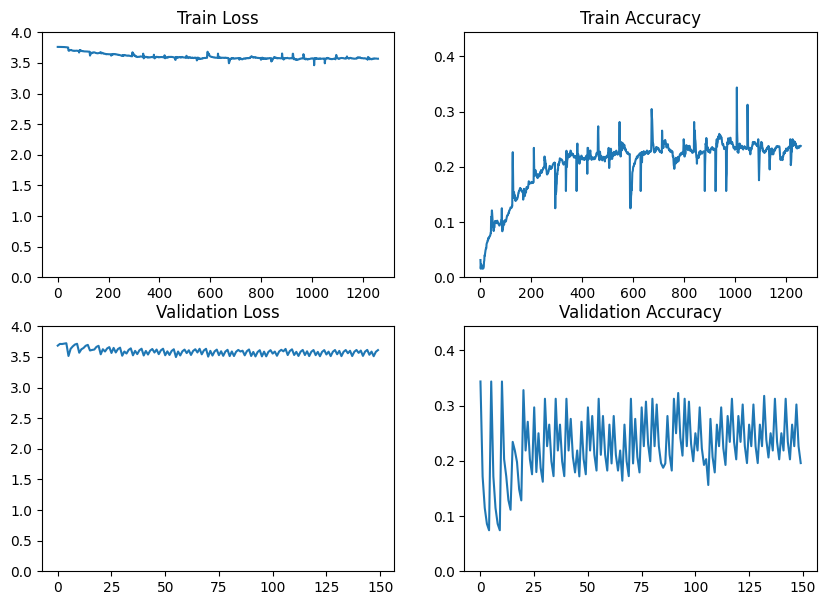

ConvReluPool Feedbacks


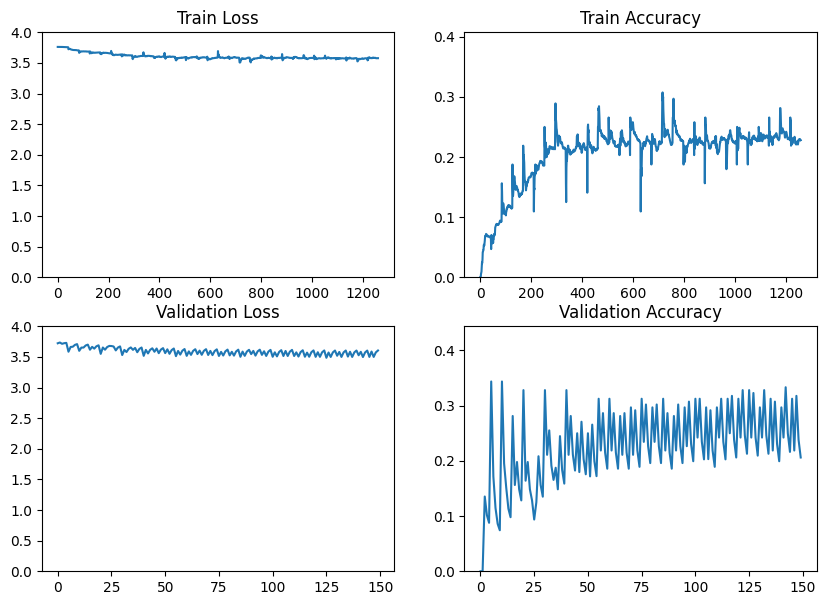

OneConvBlock Feedbacks


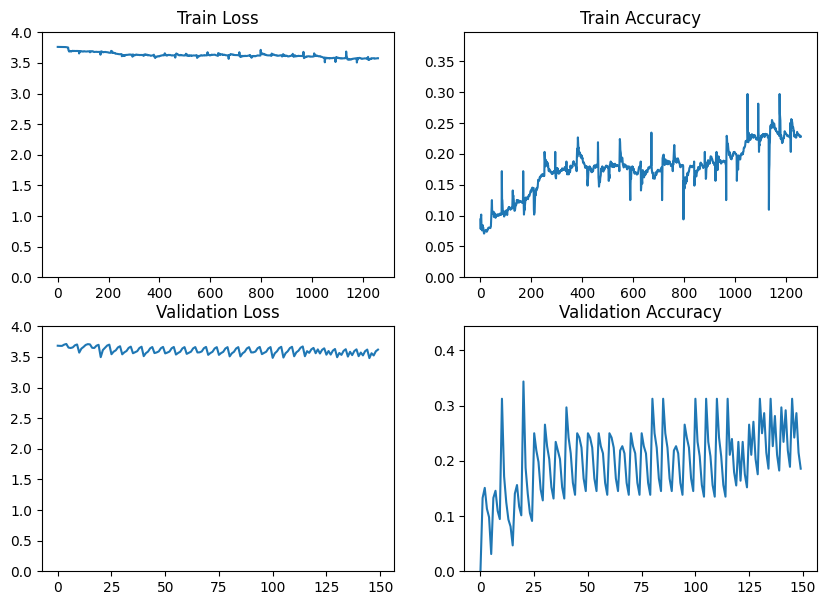

TwoConvBlock Feedbacks


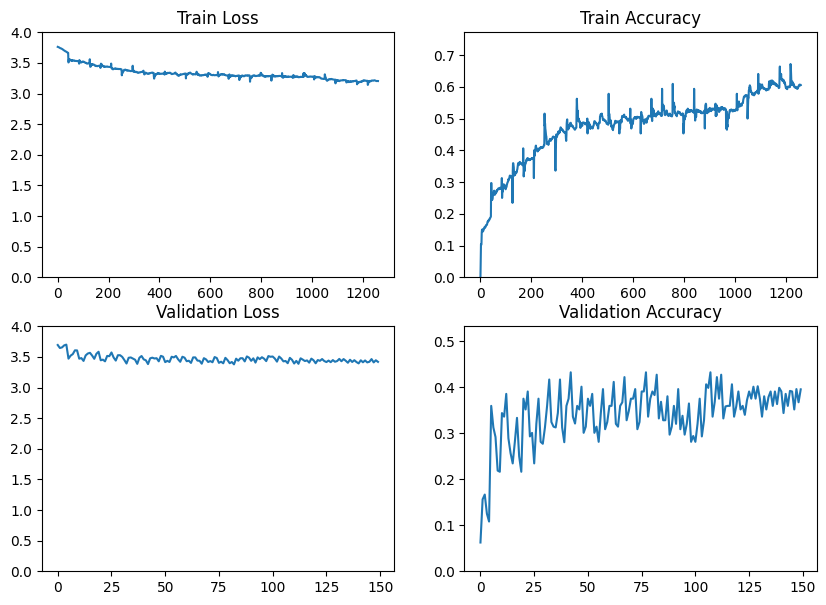

TwoResBlock Feedbacks


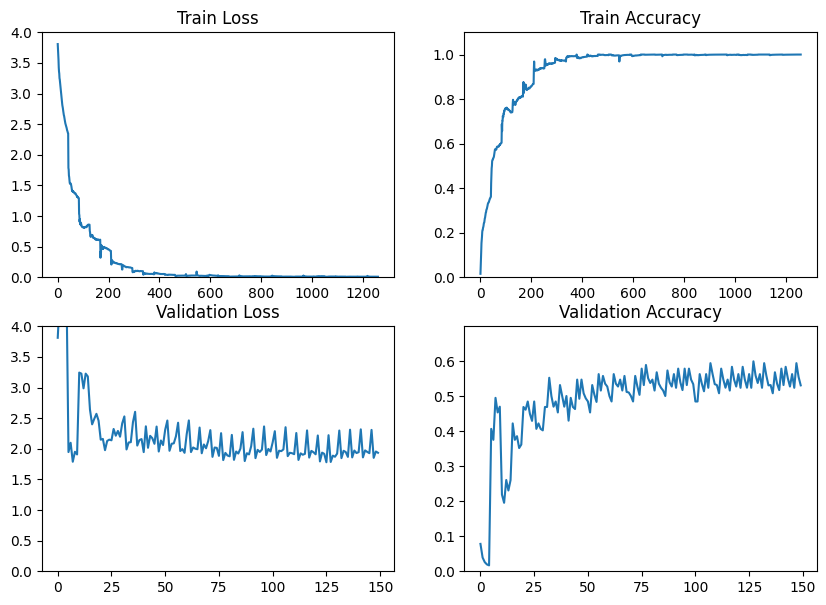

4ResBlocks Feedbacks


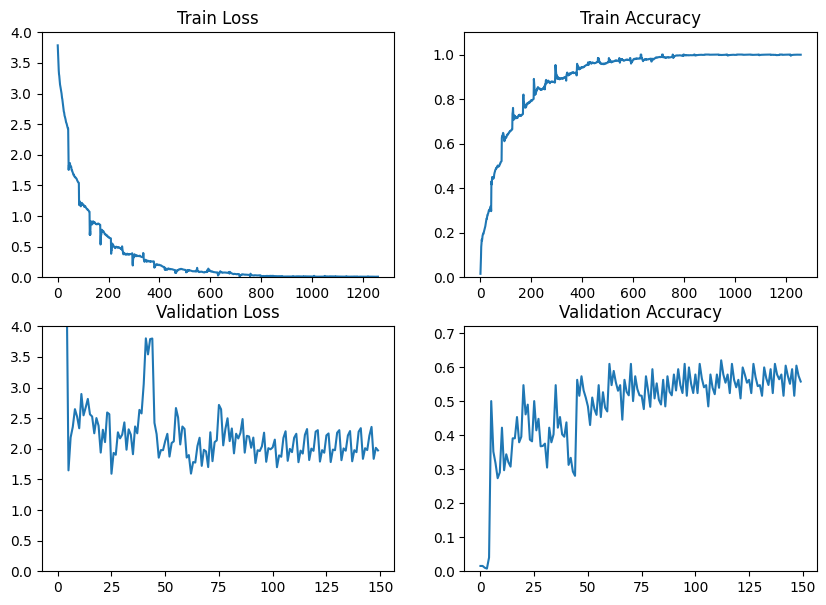

MoreFullyConnectedNet Feedbacks


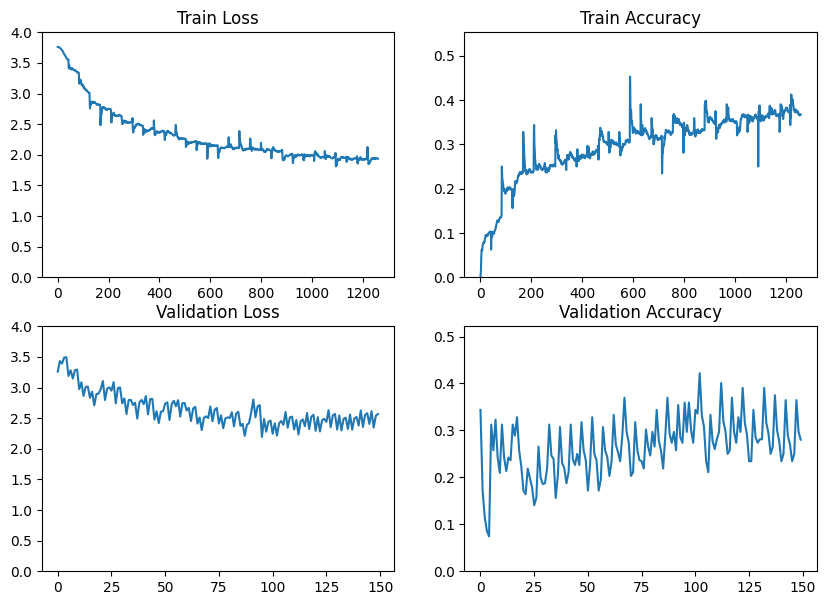

NetWithoutBatchNorm Feedbacks


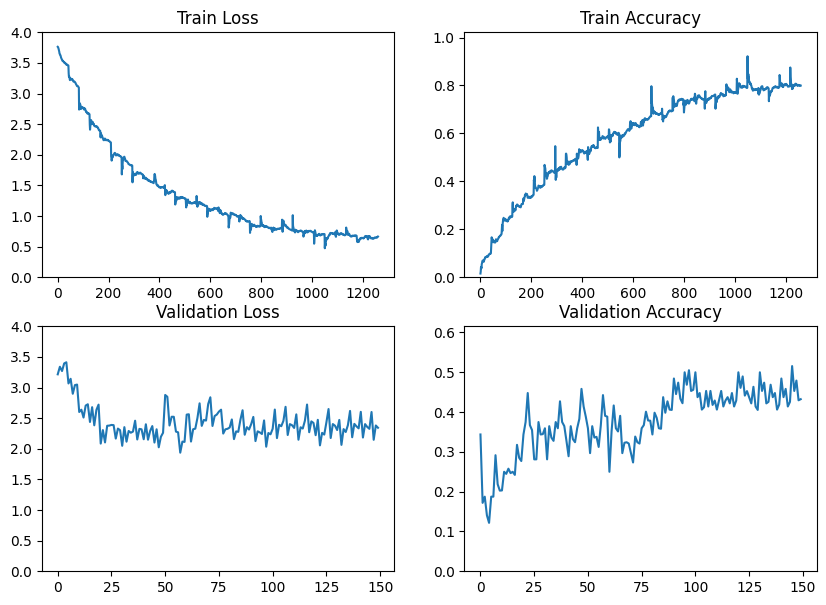

NetWithoutResidualBlock Feedbacks


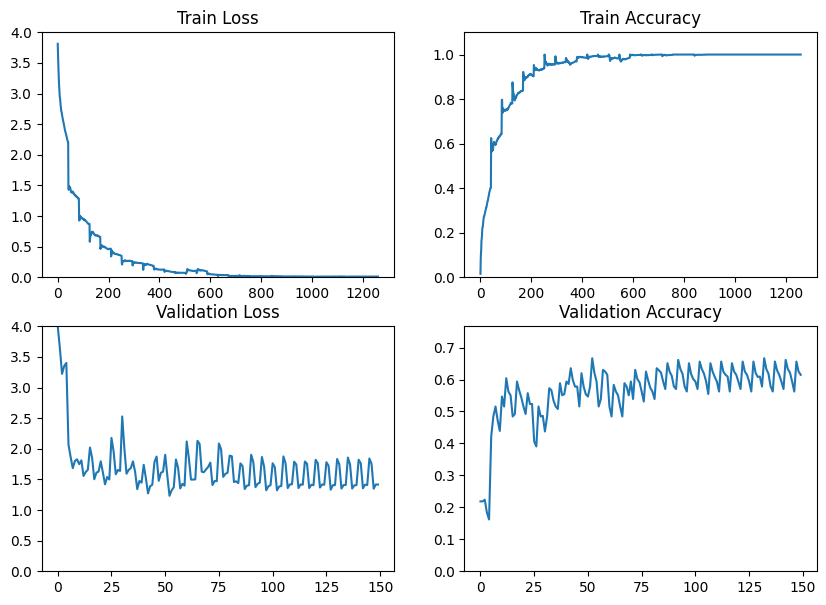

NetWihtoutDropout Feedbacks


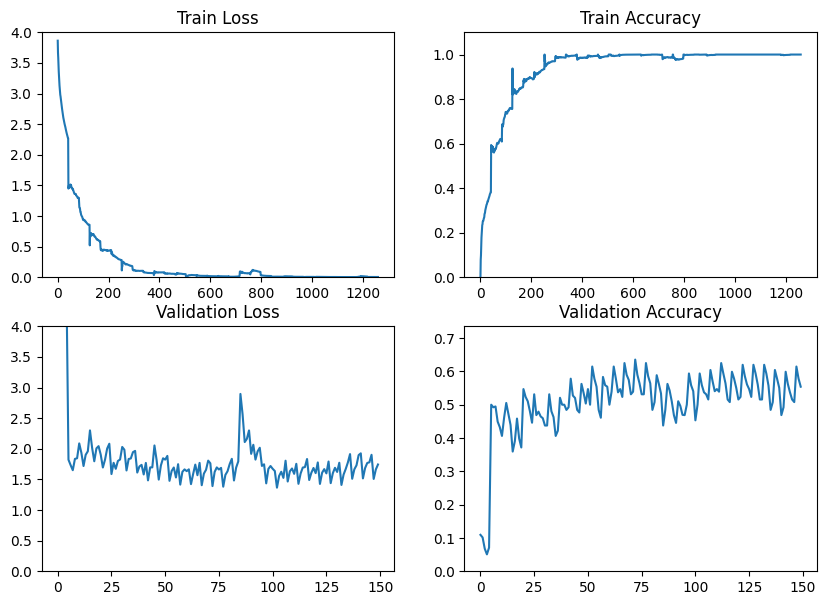

GroceryConvNet Feedbacks


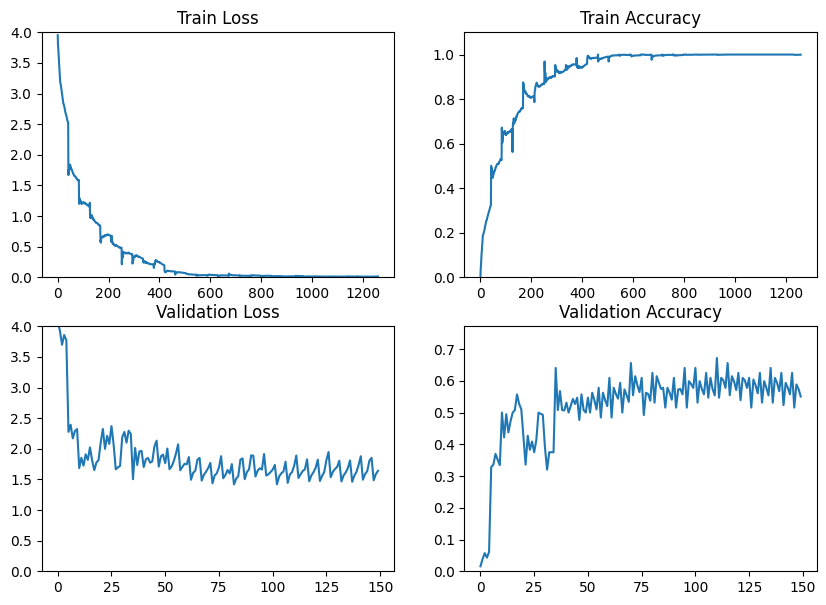

In [115]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']

for model_name in models.keys():
    if 'feedback' in models[model_name].keys():
        print(f'{model_name} Feedbacks')
        plt.figure(figsize=(10, 7))

        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.plot(range(len(models[model_name]['feedback'][i])), models[model_name]['feedback'][i])
            # plt.yscale('log')
            if i%2==1:
                plt.ylim(0, max(models[model_name]['feedback'][i]) + 0.1)
            else:
                plt.ylim(0, 4)
            plt.title(labels[i])
        plt.show()

In [ ]:
import pickle

In [105]:
# New save dictionary format 
# save = {
# 'model_name': feedback
# }
save = {}
for model_name in models.keys():
    if 'feedback' in models[model_name].keys():
        save[model_name] = models[model_name]['feedback']

In [106]:
# Storing dict in file
with open('models.pickle', 'wb') as handle:
    pickle.dump(save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
# Reading models performances saved in models.pickle
with open('models.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [108]:
b.keys()

dict_keys(['ConvRelu', 'ConvReluPool', 'OneConvBlock', 'TwoConvBlock', 'TwoResBlock', '4ResBlocks', 'MoreFullyConnectedNet', 'NetWithoutBatchNorm', 'NetWithoutResidualBlock', 'NetWihtoutDropout', 'GroceryConvNet'])